In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (20, 5)
file_path = r'../data/sales.csv'

try:
    data = pd.read_csv(file_path, dtype={'week.year': str}, sep=';', decimal=',')
    print("File loaded successfully.")
    print()
    print(data.head())
except FileNotFoundError:
    print(f"Error: File not found! Please check the path: {file_path}")
except pd.errors.ParserError:
    print("Error: There was a parsing error while reading the CSV file!")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File loaded successfully.
  country       id week.year  revenue  units
0      KR   702234   03.2019   808.08      1
1      KR   702234   06.2019  1606.80      2
2      KR  3618438   08.2019   803.40      1
3      KR  3618438   09.2019   803.40      1
4      KR  3618438   09.2019   803.40      1


In [3]:
print(data.tail())
print()
print(data.shape)
print()
print(data.info())

       country       id week.year  revenue  units
235569      CN  2452476   27.2020  41160.0    200
235570      CN  2452476   27.2020  50856.0    400
235571      CN  2452476   27.2020  79920.0   1200
235572      CN  4553904   27.2020   4788.0    100
235573      CN  4553904   27.2020   4188.0    100

(235574, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235574 entries, 0 to 235573
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    235574 non-null  object 
 1   id         235574 non-null  int64  
 2   week.year  235574 non-null  object 
 3   revenue    235574 non-null  float64
 4   units      235574 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 9.0+ MB
None


In [ ]:
data[['week', 'year']] = data['week.year'].astype(str).str.split('.', expand=True)

print(data.head())

  country       id week.year  revenue  units week  year
0      KR   702234   03.2019   808.08      1   03  2019
1      KR   702234   06.2019  1606.80      2   06  2019
2      KR  3618438   08.2019   803.40      1   08  2019
3      KR  3618438   09.2019   803.40      1   09  2019
4      KR  3618438   09.2019   803.40      1   09  2019


In [ ]:
data['date'] = pd.to_datetime(
    data['year'].astype(str) + '-W' + data['week'].astype(str) + '-1',
    format='%Y-W%W-%w'
)

print(data.head())
print()
data.columns

  country       id week.year  revenue  units week  year       date
0      KR   702234   03.2019   808.08      1   03  2019 2019-01-21
1      KR   702234   06.2019  1606.80      2   06  2019 2019-02-11
2      KR  3618438   08.2019   803.40      1   08  2019 2019-02-25
3      KR  3618438   09.2019   803.40      1   09  2019 2019-03-04
4      KR  3618438   09.2019   803.40      1   09  2019 2019-03-04



Index(['country', 'id', 'week.year', 'revenue', 'units', 'week', 'year',
       'date'],
      dtype='object')

In [6]:
data2 = data.drop(['week.year', 'week', 'year'], axis=1)
data2.rename(columns={
    'id': 'customer_id',
    'revenue': 'monetary',
    'units': 'quantity',
    'date': 'purchase_date'
}, inplace=True)

In [7]:
print(data2.info())
print()
print(data2.columns)
print()
print(data2.isnull().sum())
print()
print(data2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235574 entries, 0 to 235573
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   country        235574 non-null  object        
 1   customer_id    235574 non-null  int64         
 2   monetary       235574 non-null  float64       
 3   quantity       235574 non-null  int64         
 4   purchase_date  235574 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.0+ MB
None

Index(['country', 'customer_id', 'monetary', 'quantity', 'purchase_date'], dtype='object')

country          0
customer_id      0
monetary         0
quantity         0
purchase_date    0
dtype: int64

  country  customer_id  monetary  quantity purchase_date
0      KR       702234    808.08         1    2019-01-21
1      KR       702234   1606.80         2    2019-02-11
2      KR      3618438    803.40         1    2019-02-25
3      KR 

In [8]:
print(data2.describe())

        customer_id      monetary       quantity  \
count  2.355740e+05  2.355740e+05  235574.000000   
mean   3.193118e+06  2.840211e+03       8.599642   
min    6.000180e+05 -1.061539e+05 -150000.000000   
25%    2.214396e+06  3.994800e+02       1.000000   
50%    3.140856e+06  1.150320e+03       1.000000   
75%    3.892650e+06  2.216160e+03       2.000000   
max    2.419308e+08  2.415857e+06  150000.000000   
std    7.371744e+06  2.247532e+04     602.939290   

                       purchase_date  
count                         235574  
mean   2019-12-15 13:04:15.420377344  
min              2019-01-07 00:00:00  
25%              2019-06-24 00:00:00  
50%              2019-12-16 00:00:00  
75%              2020-06-01 00:00:00  
max              2020-11-30 00:00:00  
std                              NaN  


In [9]:
min_date = data2['purchase_date'].min()
print(f"Earliest date in dataset: {min_date}")
max_date = data2['purchase_date'].max()
print(f"Latest date in dataset: {max_date}")

Earliest date in dataset: 2019-01-07 00:00:00
Latest date in dataset: 2020-11-30 00:00:00


In [10]:
print(data2['country'].unique())
unique_countries = data2['country'].nunique()
print()
print(f"Number of unique countries: {unique_countries}")

['KR' 'PK' 'MM' 'VN' 'IN' 'SA' 'PH' 'AF' 'CN' 'BD' 'ID' 'TH' 'IQ' 'MY'
 'JP' 'IR' 'TR' 'UZ']

Number of unique countries: 18


In [11]:
country_map = {
    'AF': 'Afghanistan',
    'BD': 'Bangladesh',
    'CN': 'China',
    'IN': 'India',
    'ID': 'Indonesia',
    'IQ': 'Iraq',
    'IR': 'Iran',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MY': 'Malaysia',
    'MM': 'Myanmar',
    'PH': 'Philippines',
    'PK': 'Pakistan',
    'SA': 'Saudi Arabia',
    'TH': 'Thailand',
    'TR': 'Turkey',
    'UZ': 'Uzbekistan',
    'VN': 'Vietnam',
}

In [12]:
data2['country_clean'] = data2['country'].map(country_map)
data2['new_id'] = data2['country'].fillna('') + '-' + data2['customer_id'].fillna('').astype(str)
print(data2['country_clean'].unique())
print()
print(data2['customer_id'].nunique())

['South Korea' 'Pakistan' 'Myanmar' 'Vietnam' 'India' 'Saudi Arabia'
 'Philippines' 'Afghanistan' 'China' 'Bangladesh' 'Indonesia' 'Thailand'
 'Iraq' 'Malaysia' 'Japan' 'Iran' 'Turkey' 'Uzbekistan']

21837


In [13]:
data2['country'] = data2['country_clean']
data2 = data2.drop(columns=['country_clean'])
print(data2.head())

       country  customer_id  monetary  quantity purchase_date      new_id
0  South Korea       702234    808.08         1    2019-01-21   KR-702234
1  South Korea       702234   1606.80         2    2019-02-11   KR-702234
2  South Korea      3618438    803.40         1    2019-02-25  KR-3618438
3  South Korea      3618438    803.40         1    2019-03-04  KR-3618438
4  South Korea      3618438    803.40         1    2019-03-04  KR-3618438


In [14]:
data3 = data2.set_index("purchase_date")
print(data3.head())

                   country  customer_id  monetary  quantity      new_id
purchase_date                                                          
2019-01-21     South Korea       702234    808.08         1   KR-702234
2019-02-11     South Korea       702234   1606.80         2   KR-702234
2019-02-25     South Korea      3618438    803.40         1  KR-3618438
2019-03-04     South Korea      3618438    803.40         1  KR-3618438
2019-03-04     South Korea      3618438    803.40         1  KR-3618438


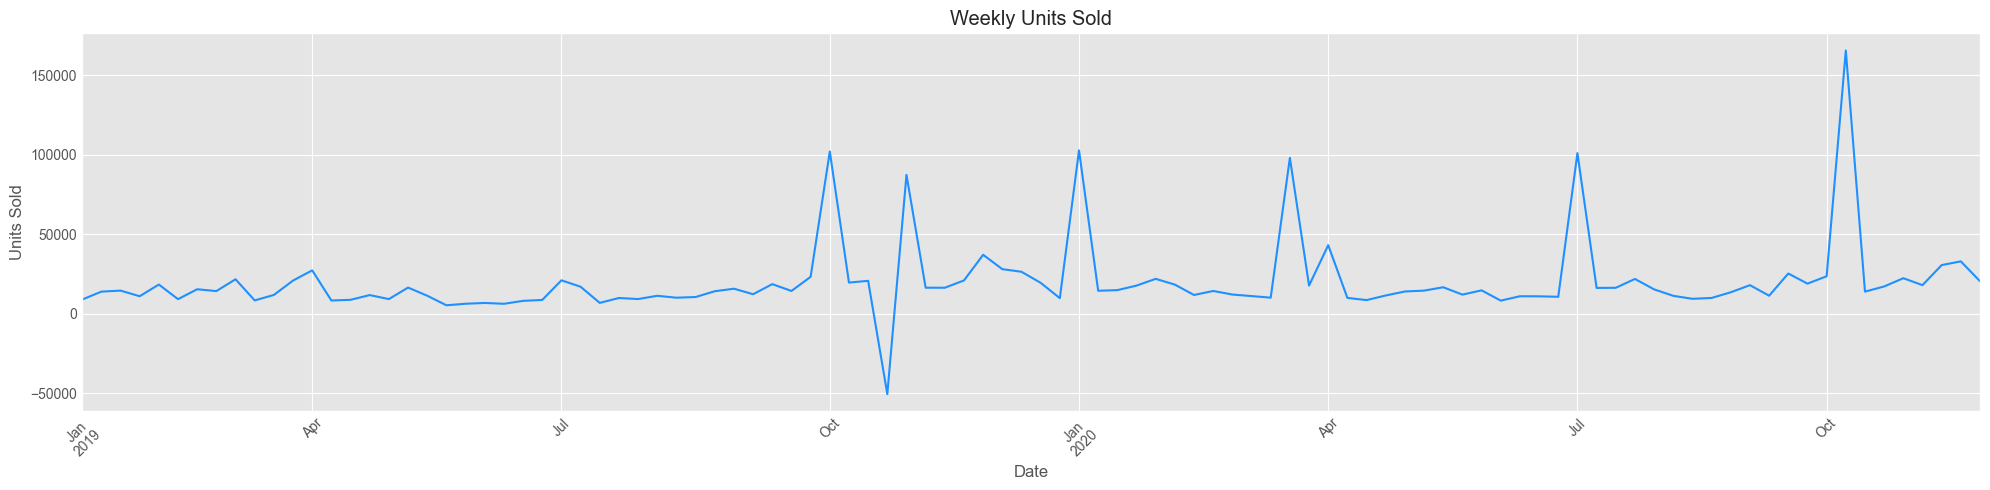

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 5))
weekly_quantity = data2.groupby('purchase_date')['quantity'].sum()
weekly_quantity.plot(color='dodgerblue')
plt.title('Weekly Units Sold')
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

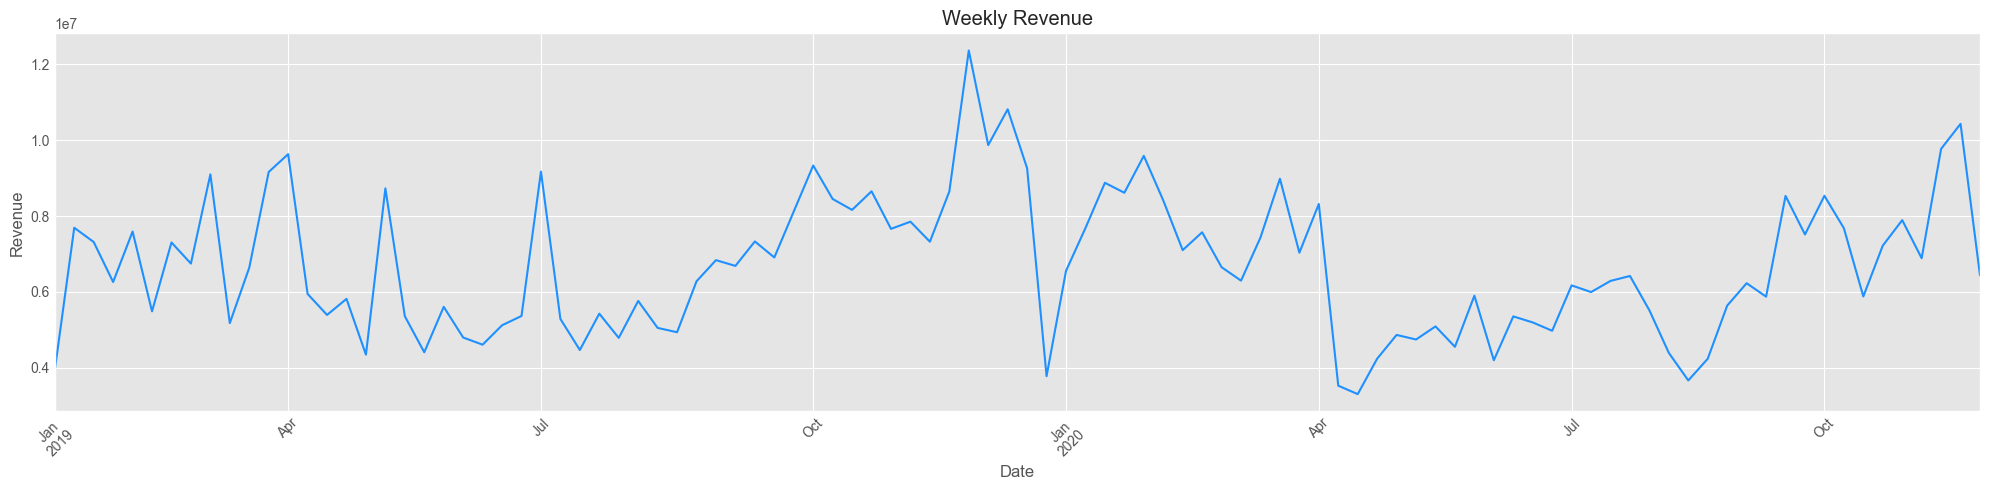

In [16]:
plt.figure(figsize=(20, 5))
weekly_revenue = data2.groupby('purchase_date')['monetary'].sum()
weekly_revenue.plot(color='dodgerblue')
plt.title('Weekly Revenue')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
data4 = data3.to_period("M")
print(data4.head())

                   country  customer_id  monetary  quantity      new_id
purchase_date                                                          
2019-01        South Korea       702234    808.08         1   KR-702234
2019-02        South Korea       702234   1606.80         2   KR-702234
2019-02        South Korea      3618438    803.40         1  KR-3618438
2019-03        South Korea      3618438    803.40         1  KR-3618438
2019-03        South Korea      3618438    803.40         1  KR-3618438


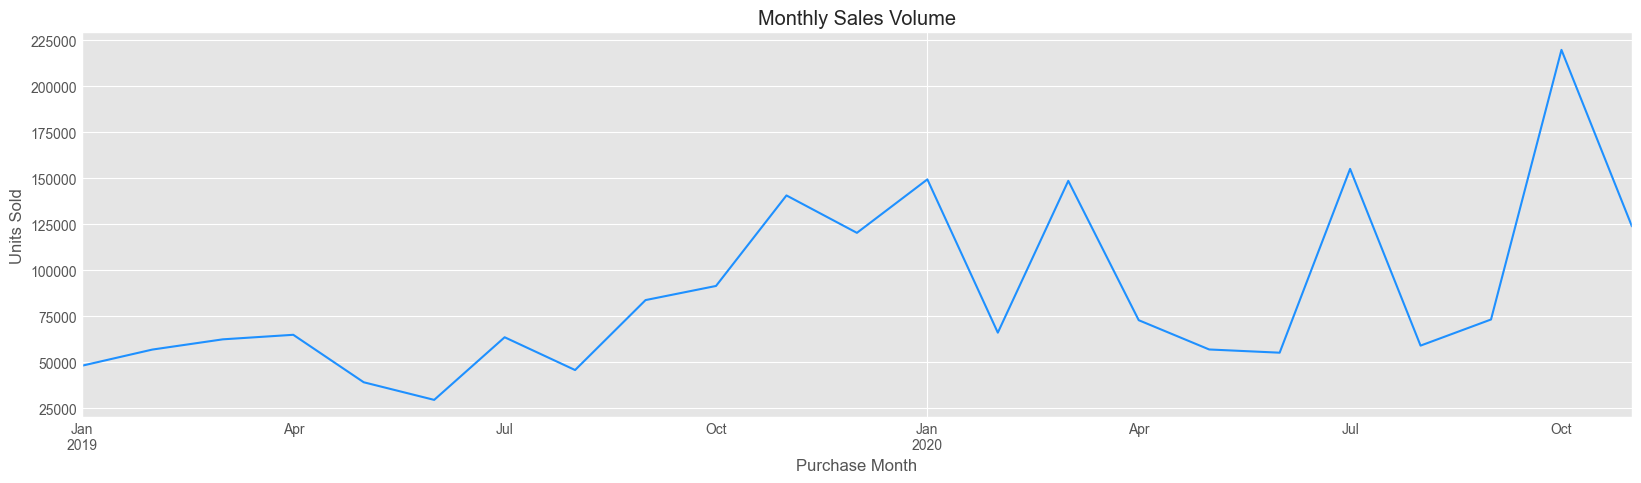

In [18]:
plt.figure(figsize=(20, 5))
data4['quantity'].groupby('purchase_date').sum().plot(color='dodgerblue')
plt.title('Monthly Sales Volume')
plt.ylabel('Units Sold')
plt.xlabel('Purchase Month')
plt.show()

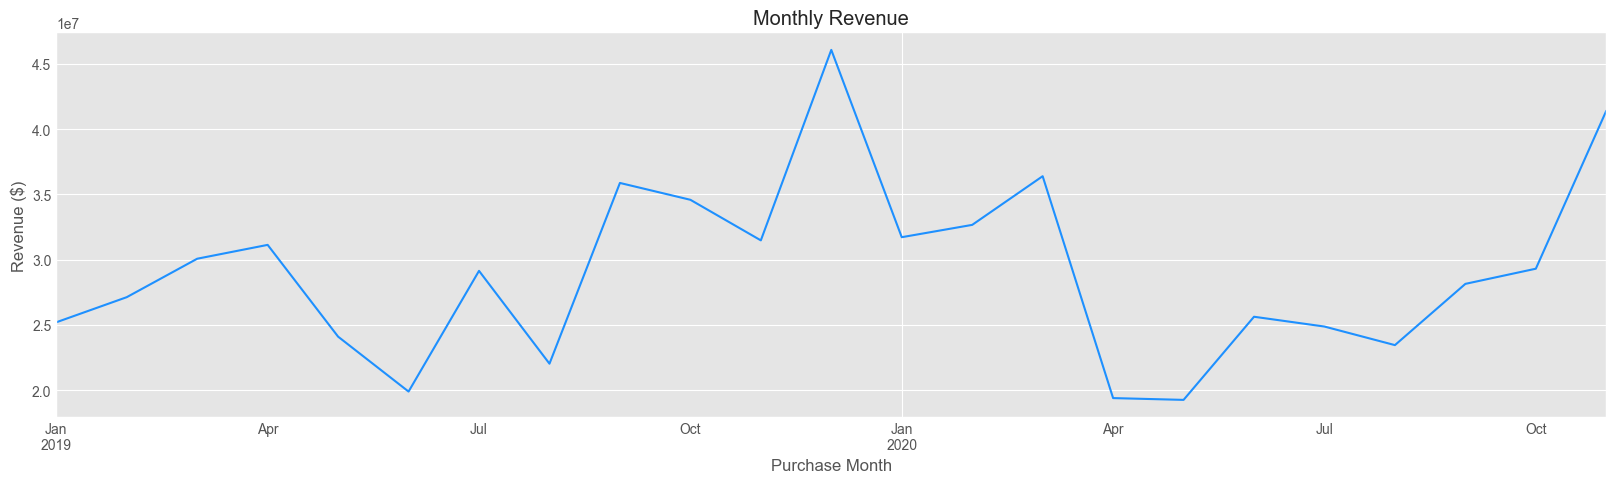

In [19]:
plt.figure(figsize=(20, 5))
data4['monetary'].groupby('purchase_date').sum().plot(color='dodgerblue')
plt.title('Monthly Revenue')
plt.ylabel('Revenue ($)')
plt.xlabel('Purchase Month')
plt.show()

In [20]:
print('Sales from {} to {}'.format(data2['purchase_date'].min(), data2['purchase_date'].max()))

period = 365
date_N_days_ago = data2['purchase_date'].max() - timedelta(days=period)
data2 = data2[data2['purchase_date'] > date_N_days_ago]
data2.reset_index(drop=True, inplace=True)

print(data2.head())
print()
print(data2.info())

Sales from 2019-01-07 00:00:00 to 2020-11-30 00:00:00
       country  customer_id  monetary  quantity purchase_date      new_id
0  South Korea      4375152    773.58         1    2019-12-16  KR-4375152
1  South Korea       705462    337.26         1    2019-12-09   KR-705462
2  South Korea       705462    337.26         1    2019-12-23   KR-705462
3  South Korea       705462    421.56         2    2019-12-16   KR-705462
4  South Korea       706854    391.50         1    2019-12-09   KR-706854

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124640 entries, 0 to 124639
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   country        124640 non-null  object        
 1   customer_id    124640 non-null  int64         
 2   monetary       124640 non-null  float64       
 3   quantity       124640 non-null  int64         
 4   purchase_date  124640 non-null  datetime64[ns]
 5   new_id         124640 

In [21]:
data5 = data2.copy()
NOW = data5['purchase_date'].max() + timedelta(days=1)
print(f"Analysis date (NOW): {NOW}")

Analysis date (NOW): 2020-12-01 00:00:00


In [22]:
data5['days_since_purchase'] = data5['purchase_date'].apply(lambda x: (NOW - x).days)
print(data5.head())

       country  customer_id  monetary  quantity purchase_date      new_id  \
0  South Korea      4375152    773.58         1    2019-12-16  KR-4375152   
1  South Korea       705462    337.26         1    2019-12-09   KR-705462   
2  South Korea       705462    337.26         1    2019-12-23   KR-705462   
3  South Korea       705462    421.56         2    2019-12-16   KR-705462   
4  South Korea       706854    391.50         1    2019-12-09   KR-706854   

   days_since_purchase  
0                  351  
1                  358  
2                  344  
3                  351  
4                  358  


In [23]:
print(data5[data5['new_id'] == 'KR-706854'])

           country  customer_id  monetary  quantity purchase_date     new_id  \
4      South Korea       706854    391.50         1    2019-12-09  KR-706854   
5      South Korea       706854    388.68         1    2019-12-30  KR-706854   
14169  South Korea       706854    369.66         1    2020-04-06  KR-706854   
14192  South Korea       706854    374.76         1    2020-07-27  KR-706854   
14210  South Korea       706854    371.82         1    2020-11-09  KR-706854   

       days_since_purchase  
4                      358  
5                      337  
14169                  239  
14192                  127  
14210                   22  


In [24]:
aggr = {
    'days_since_purchase': 'min',
    'purchase_date': lambda dates: sum(date >= NOW - timedelta(days=period) for date in dates)
}

In [25]:
rfm = (
    data5
    .groupby(['customer_id', 'new_id', 'country'])
    .agg(aggr)
    .reset_index()
    .rename(columns={
        'days_since_purchase': 'recency',
        'purchase_date': 'frequency'
    })
)
print(rfm.head())

   customer_id     new_id country  recency  frequency
0       600018  CN-600018   China       29          7
1       600060  CN-600060   China      155          1
2       600462  CN-600462   China      211          2
3       600888  CN-600888   China        8          3
4       601014  CN-601014   China      225          1


In [26]:
recent_data = data5[data5['purchase_date'] >= NOW - timedelta(days=period)]
monetary_sum = recent_data.groupby('new_id')['monetary'].sum()
rfm['monetary'] = rfm['new_id'].map(monetary_sum).fillna(0)
print(rfm.head())

   customer_id     new_id country  recency  frequency  monetary
0       600018  CN-600018   China       29          7  21402.78
1       600060  CN-600060   China      155          1   1201.14
2       600462  CN-600462   China      211          2   2033.64
3       600888  CN-600888   China        8          3   2335.80
4       601014  CN-601014   China      225          1    230.52


In [27]:
max_monetary = rfm['monetary'].max()
print(f"Highest monetary customer(s):")
print(rfm[rfm['monetary'] == max_monetary])

Highest monetary customer(s):
     customer_id     new_id country  recency  frequency     monetary
173       638544  CN-638544   China        1        217  21482332.56


In [28]:
max_frequency = rfm['frequency'].max()
print(f"Highest frequency customer(s):")
print(rfm[rfm['frequency'] == max_frequency])

Highest frequency customer(s):
      customer_id      new_id country  recency  frequency    monetary
8290      3249114  TR-3249114  Turkey        1       1351  2731448.04


In [29]:
rfm = rfm.drop(columns=['new_id'])

In [30]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8])
print("Quintiles:")
print(quintiles)

Quintiles:
     recency  frequency   monetary
0.2     15.0        1.0    967.500
0.4     50.0        2.0   2212.200
0.6    120.0        4.0   4852.548
0.8    239.0        9.0  13957.500


In [31]:
def r_score(x):
    if x <= quintiles.loc[0.2, 'recency']:
        return 5
    elif x <= quintiles.loc[0.4, 'recency']:
        return 4
    elif x <= quintiles.loc[0.6, 'recency']:
        return 3
    elif x <= quintiles.loc[0.8, 'recency']:
        return 2
    else:
        return 1

In [32]:
def fm_score(x, column):
    if x <= quintiles.loc[0.2, column]:
        return 1
    elif x <= quintiles.loc[0.4, column]:
        return 2
    elif x <= quintiles.loc[0.6, column]:
        return 3
    elif x <= quintiles.loc[0.8, column]:
        return 4
    else:
        return 5

In [33]:
rfm['r'] = rfm['recency'].apply(r_score)
rfm['f'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['m'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

print(rfm.head())

   customer_id country  recency  frequency  monetary  r  f  m
0       600018   China       29          7  21402.78  4  4  5
1       600060   China      155          1   1201.14  2  1  2
2       600462   China      211          2   2033.64  2  2  2
3       600888   China        8          3   2335.80  5  3  3
4       601014   China      225          1    230.52  2  1  1


In [34]:
rfm['rfm_score'] = rfm[['r', 'f', 'm']].astype(str).agg(''.join, axis=1)
rfm['fm'] = ((rfm['f'] + rfm['m']) / 2).apply(math.trunc)
print(rfm.head())

   customer_id country  recency  frequency  monetary  r  f  m rfm_score  fm
0       600018   China       29          7  21402.78  4  4  5       445   4
1       600060   China      155          1   1201.14  2  1  2       212   1
2       600462   China      211          2   2033.64  2  2  2       222   2
3       600888   China        8          3   2335.80  5  3  3       533   3
4       601014   China      225          1    230.52  2  1  1       211   1


In [35]:
segment_map = {
    '11': 'hibernating',
    '12': 'hibernating', 
    '21': 'hibernating',
    '22': 'hibernating',
    '13': 'at risk',
    '14': 'at risk',
    '15': 'can\'t lose',
    '23': 'at risk',
    '24': 'at risk',
    '25': 'at risk',
    '31': 'about to sleep',
    '32': 'about to sleep',
    '33': 'need attention',
    '34': 'loyal customers',
    '35': 'loyal customers',
    '41': 'promising',
    '42': 'potential loyalists',
    '43': 'potential loyalists',
    '44': 'loyal customers',
    '45': 'loyal customers',
    '51': 'new customers',
    '52': 'potential loyalists',
    '53': 'potential loyalists',
    '54': 'loyal customers',
    '55': 'champions'
}

In [36]:
rfm['segment_key'] = rfm['r'].astype(str) + rfm['fm'].astype(str)
rfm['segment'] = rfm['segment_key'].map(segment_map)

In [37]:
unmapped = rfm[rfm['segment'].isna()]['segment_key'].unique()
if len(unmapped) > 0:
    print(f"Unmapped segment keys: {unmapped}")
    rfm['segment'] = rfm['segment'].fillna('other')

In [38]:
print(rfm.head())
print()
print(rfm.isnull().sum())

   customer_id country  recency  frequency  monetary  r  f  m rfm_score  fm  \
0       600018   China       29          7  21402.78  4  4  5       445   4   
1       600060   China      155          1   1201.14  2  1  2       212   1   
2       600462   China      211          2   2033.64  2  2  2       222   2   
3       600888   China        8          3   2335.80  5  3  3       533   3   
4       601014   China      225          1    230.52  2  1  1       211   1   

  segment_key              segment  
0          44      loyal customers  
1          21          hibernating  
2          22          hibernating  
3          53  potential loyalists  
4          21          hibernating  

customer_id    0
country        0
recency        0
frequency      0
monetary       0
r              0
f              0
m              0
rfm_score      0
fm             0
segment_key    0
segment        0
dtype: int64


In [39]:
print(f"Unique segments: {rfm['segment'].unique()}")

Unique segments: ['loyal customers' 'hibernating' 'potential loyalists' 'new customers'
 'need attention' 'at risk' 'champions' 'about to sleep' 'promising'
 "can't lose"]


In [40]:
print("\nCan't lose customers (top by monetary):")
cant_lose = rfm[rfm['segment'] == "can't lose"].sort_values(by='monetary', ascending=False)
print(cant_lose)


Can't lose customers (top by monetary):
       customer_id       country  recency  frequency   monetary  r  f  m  \
13028      4096386         Japan      260        105  220267.86  1  5  5   
3502       2443284         India      246         10  102208.02  1  5  5   
14174      4262646         India      316         10   91909.44  1  5  5   
2435       1803672         India      267         12   70506.96  1  5  5   
13254      4132968       Vietnam      253         26   42535.14  1  5  5   
11222      3815274         India      267         11   37968.72  1  5  5   
1458       1031454   Philippines      267         23   31833.30  1  5  5   
5437       2809158         India      274         12   27150.12  1  5  5   
14644      4326906         India      337         11   22351.68  1  5  5   
259         668070       Myanmar      267         11   21886.92  1  5  5   
15331      4418268  Saudi Arabia      302         10   14295.54  1  5  5   

      rfm_score  fm segment_key     segment  


In [41]:
print("\nNeed attention customers (top 10 by monetary):")
need_attention = rfm[rfm['segment'] == 'need attention'].sort_values(by='monetary', ascending=False).head(10)
print(need_attention)


Need attention customers (top 10 by monetary):
       customer_id      country  recency  frequency  monetary  r  f  m  \
8245       3242664       Turkey       64          1  73823.58  3  1  5   
13065      4107798        Japan      120          2  67257.48  3  2  5   
9847       3561900    Indonesia      120          1  59700.00  3  1  5   
6626       2921070    Indonesia       71          2  34730.22  3  2  5   
10009      3587772        China       92          1  29961.00  3  1  5   
3087       2131194        Japan       57          1  28543.74  3  1  5   
13463      4160490        Japan       99          1  24842.22  3  1  5   
1251        993414  South Korea       71          2  22018.32  3  2  5   
3936       2544588   Bangladesh       71          2  19043.82  3  2  5   
3616       2468010     Thailand       85          2  18599.58  3  2  5   

      rfm_score  fm segment_key         segment  
8245        315   3          33  need attention  
13065       325   3          33  need

In [42]:
print("\nLoyal customers (top 10 by monetary):")
loyal = rfm[rfm['segment'] == 'loyal customers'].sort_values(by='monetary', ascending=False).head(10)
print(loyal)


Loyal customers (top 10 by monetary):
       customer_id      country  recency  frequency    monetary  r  f  m  \
15420      4422780       Turkey       92         13  2315341.14  3  5  5   
2882       2030526        Japan       22         50  1519339.86  4  5  5   
3220       2182446        Japan       29         18  1492057.68  4  5  5   
12660      4041366     Pakistan       50          9   736626.96  4  4  5   
5612       2853774      Vietnam        8          6   712230.00  5  4  5   
10343      3649728  Philippines       29         81   579167.52  4  5  5   
8284       3248568       Turkey       64          3   573792.72  3  3  5   
15450      4427148        India       29         14   502843.32  4  5  5   
14678      4332210    Indonesia       43         21   474773.40  4  5  5   
2802       1985592         Iraq       78          4   460390.86  3  3  5   

      rfm_score  fm segment_key          segment  
15420       355   5          35  loyal customers  
2882        455   5   

In [43]:
print("\nChampions (top 10 by monetary):")
champions = rfm[rfm['segment'] == 'champions'].sort_values(by='monetary', ascending=False).head(10)
print(champions)


Champions (top 10 by monetary):
       customer_id      country  recency  frequency     monetary  r  f  m  \
173         638544        China        1        217  21482332.56  5  5  5   
15436      4424580        China        1        104  16912322.46  5  5  5   
14754      4341960       Turkey        1        200  16550997.90  5  5  5   
11942      3929094    Indonesia        1        470   8748884.64  5  5  5   
9626       3520734        Japan        1        198   6207519.96  5  5  5   
15915      4494150       Turkey        1         57   4874668.14  5  5  5   
10168      3618438  South Korea        8       1020   4615660.08  5  5  5   
14027      4245048  Philippines        1        993   4358515.98  5  5  5   
3050       2111100        India        1        876   4270717.80  5  5  5   
11742      3894492  Philippines        8         63   4106366.22  5  5  5   

      rfm_score  fm segment_key    segment  
173         555   5          55  champions  
15436       555   5          

In [44]:
avg_monetary = rfm['monetary'].mean()
print(f"\nAverage monetary value: {avg_monetary:.2f}")


Average monetary value: 21629.61


In [45]:
high_value_need_attention = rfm[
    (rfm['monetary'] > avg_monetary) & (rfm['segment'] == 'need attention')
].sort_values(by='monetary', ascending=False)
print(f"\nHigh-value 'need attention' customers:")
print(high_value_need_attention)


High-value 'need attention' customers:
       customer_id      country  recency  frequency  monetary  r  f  m  \
8245       3242664       Turkey       64          1  73823.58  3  1  5   
13065      4107798        Japan      120          2  67257.48  3  2  5   
9847       3561900    Indonesia      120          1  59700.00  3  1  5   
6626       2921070    Indonesia       71          2  34730.22  3  2  5   
10009      3587772        China       92          1  29961.00  3  1  5   
3087       2131194        Japan       57          1  28543.74  3  1  5   
13463      4160490        Japan       99          1  24842.22  3  1  5   
1251        993414  South Korea       71          2  22018.32  3  2  5   

      rfm_score  fm segment_key         segment  
8245        315   3          33  need attention  
13065       325   3          33  need attention  
9847        315   3          33  need attention  
6626        325   3          33  need attention  
10009       315   3          33  need atten

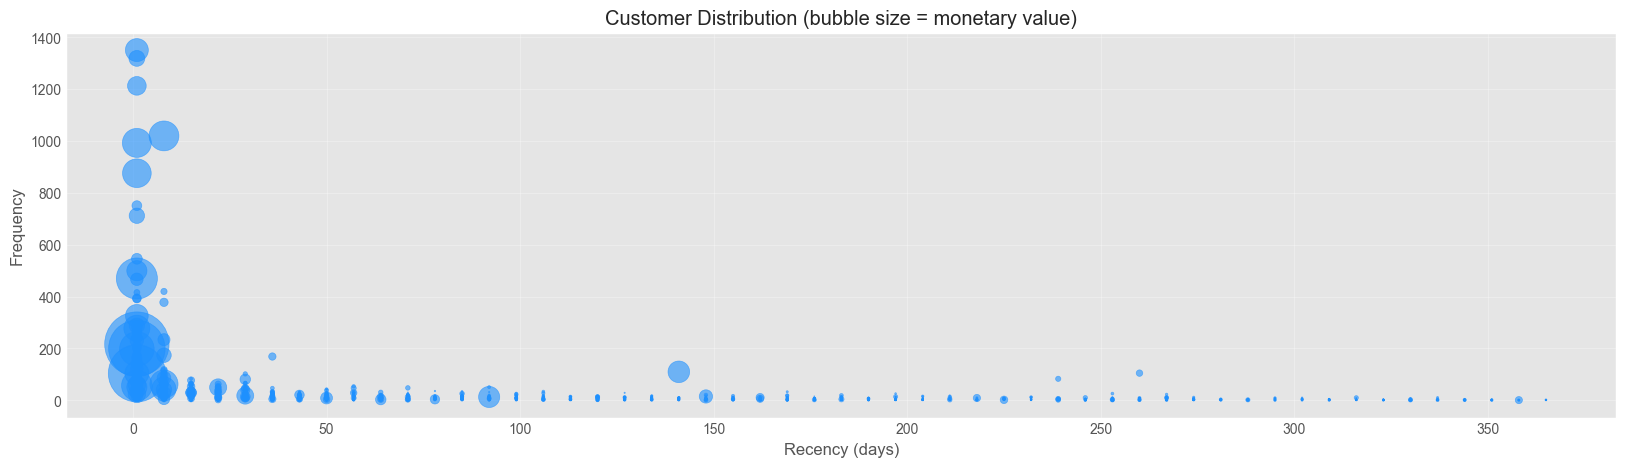

In [46]:
plt.figure(figsize=(20, 5))
plt.scatter(rfm['recency'], rfm['frequency'], s=rfm['monetary']*0.0001, c='dodgerblue', alpha=0.6)
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Customer Distribution (bubble size = monetary value)')
plt.grid(True, alpha=0.3)
plt.show()

In [47]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

In [ ]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

In [ ]:
print("Silhouette scores:", [round(s, 3) for s in silhouette_scores])

Silhouette scores: [0.969, 0.617, 0.617, 0.627, 0.549, 0.572, 0.572, 0.548, 0.509]


In [ ]:
manual_k = 4
print(f"Optimal K based on silhouette score: {k_range[np.argmax(silhouette_scores)]}")
print(f"Manually selected K (more balanced): {manual_k}")

Optimal K based on silhouette score: 2
Manually selected K (more balanced): 4


In [ ]:
optimal_kmeans = KMeans(n_clusters=k_range[np.argmax(silhouette_scores)], random_state=42, n_init=10)
rfm['kmeans_optimal'] = optimal_kmeans.fit_predict(rfm_scaled)

manual_kmeans = KMeans(n_clusters=manual_k, random_state=42, n_init=10)
rfm['kmeans_cluster'] = manual_kmeans.fit_predict(rfm_scaled)

print(f"\nOptimal K-Means (K={k_range[np.argmax(silhouette_scores)]}) cluster distribution:")
print(rfm['kmeans_optimal'].value_counts().sort_index())

print(f"\nManual K-Means (K={manual_k}) cluster distribution:")
print(rfm['kmeans_cluster'].value_counts().sort_index())


Optimal K-Means (K=2) cluster distribution:
kmeans_optimal
0    16556
1       13
Name: count, dtype: int64

Manual K-Means (K=4) cluster distribution:
kmeans_cluster
0    10689
1     5866
2        3
3       11
Name: count, dtype: int64


In [ ]:
manual_cluster_balance = rfm['kmeans_cluster'].value_counts()
min_cluster_size = manual_cluster_balance.min()
max_cluster_size = manual_cluster_balance.max()
balance_ratio = min_cluster_size / max_cluster_size

print(f"Manual clustering balance ratio: {balance_ratio:.3f} (closer to 1.0 is better)")
print(f"K-Means Manual Silhouette Score: {silhouette_score(rfm_scaled, rfm['kmeans_cluster']):.3f}")
print(f"K-Means Optimal Silhouette Score: {max(silhouette_scores):.3f}")

Manual clustering balance ratio: 0.000 (closer to 1.0 is better)
K-Means Manual Silhouette Score: 0.617
K-Means Optimal Silhouette Score: 0.969


In [ ]:
epsilon = distances[int(len(distances) * 0.95)]
print(f"Optimal epsilon value: {epsilon:.3f}")

dbscan = DBSCAN(eps=epsilon, min_samples=5)
rfm['dbscan_cluster'] = dbscan.fit_predict(rfm_scaled)

In [ ]:
n_clusters_dbscan = len(set(rfm['dbscan_cluster'])) - (1 if -1 in rfm['dbscan_cluster'] else 0)
n_noise = list(rfm['dbscan_cluster']).count(-1)
print(f"DBSCAN number of clusters: {n_clusters_dbscan}")
print(f"Number of customers detected as noise by DBSCAN: {n_noise}")

DBSCAN number of clusters: 11
Number of customers detected as noise by DBSCAN: 737


In [ ]:
kmeans_analysis = rfm.groupby('kmeans_cluster').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
kmeans_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
print("K-Means Cluster Analysis:")
print(kmeans_analysis)

K-Means Cluster Analysis:
                Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary
kmeans_cluster                                                          
0                        16556       118.42           6.96      16166.43
1                           13         1.54         724.92    6979201.43


In [ ]:
dbscan_clean = rfm[rfm['dbscan_cluster'] != -1]
if len(dbscan_clean) > 0:
    dbscan_analysis = dbscan_clean.groupby('dbscan_cluster').agg({
        'customer_id': 'count',
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean'
    }).round(2)
    dbscan_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
    print("\nDBSCAN Cluster Analysis (excluding noise):")
    print(dbscan_analysis)


DBSCAN Cluster Analysis (excluding noise):
                Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary
dbscan_cluster                                                          
0                        15779       121.33           5.15       8308.47
1                            5         1.00          41.40      69384.80
2                            5        36.00          27.20      42681.96
3                           11        90.09          14.55      22138.89
4                            5       155.00          12.60      15953.81
5                            3        29.00          24.33      69644.22
6                            8         2.75          44.75      86834.20
7                            7        63.00          19.00      22325.86
8                            5         8.00          41.60     179100.19
9                            4         9.75          14.00     119171.79


In [ ]:
cohort_data = data5.copy()
cohort_data['purchase_period'] = cohort_data['purchase_date'].dt.to_period('M')

In [ ]:
cohort_data['cohort_group'] = cohort_data.groupby('customer_id')['purchase_date'].transform('min').dt.to_period('M')

In [ ]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year * 12 + month

cohort_data['purchase_period_int'] = get_date_int(cohort_data, 'purchase_period')
cohort_data['cohort_group_int'] = get_date_int(cohort_data, 'cohort_group')
cohort_data['period_number'] = cohort_data['purchase_period_int'] - cohort_data['cohort_group_int'] + 1

In [ ]:
cohort_table = cohort_data.pivot_table(index='cohort_group',
                                      columns='period_number',
                                      values='customer_id',
                                      aggfunc='nunique')

In [ ]:
cohort_sizes = cohort_data.groupby('cohort_group')['customer_id'].nunique()

In [ ]:
retention_table = cohort_table.divide(cohort_sizes, axis=0)

print("COHORT RETENTION RATE TABLE (First 12 Periods):")
print(retention_table.iloc[:, :12].round(3))

COHORT RETENTION RATE TABLE (First 12 Periods):
period_number   1      2      3      4      5      6      7      8      9   \
cohort_group                                                                 
2019-12        1.0  0.518  0.515  0.516  0.369  0.407  0.462  0.394  0.407   
2020-01        1.0  0.334  0.344  0.201  0.235  0.289  0.235  0.252  0.260   
2020-02        1.0  0.284  0.145  0.152  0.212  0.173  0.169  0.189  0.200   
2020-03        1.0  0.131  0.143  0.201  0.157  0.149  0.164  0.166  0.171   
2020-04        1.0  0.150  0.183  0.125  0.127  0.145  0.147  0.176    NaN   
2020-05        1.0  0.220  0.158  0.133  0.161  0.161  0.166    NaN    NaN   
2020-06        1.0  0.143  0.131  0.153  0.149  0.162    NaN    NaN    NaN   
2020-07        1.0  0.135  0.118  0.152  0.152    NaN    NaN    NaN    NaN   
2020-08        1.0  0.167  0.154  0.161    NaN    NaN    NaN    NaN    NaN   
2020-09        1.0  0.150  0.134    NaN    NaN    NaN    NaN    NaN    NaN   
2020-10        1

In [ ]:
avg_retention = retention_table.mean().round(3)
print(f"\nAverage Retention Rates:")
for period, rate in avg_retention.head(12).items():
    print(f"Period {period}: %{rate*100:.1f}")


Average Retention Rates:
Period 1: %100.0
Period 2: %21.6
Period 3: %20.3
Period 4: %19.9
Period 5: %19.5
Period 6: %21.2
Period 7: %22.4
Period 8: %23.5
Period 9: %25.9
Period 10: %30.7
Period 11: %35.8
Period 12: %45.8


In [ ]:
clv_data = rfm.copy()

In [ ]:
analysis_period = 365 

In [ ]:
clv_data['aov'] = np.where(clv_data['frequency'] > 0, 
                          clv_data['monetary'] / clv_data['frequency'], 
                          clv_data['monetary'])

In [ ]:
clv_data['purchase_frequency_yearly'] = np.clip(
    clv_data['frequency'] * (365 / analysis_period), 
    0.1, 50
)

In [ ]:
clv_data['estimated_lifespan_years'] = np.clip(
    365 / (clv_data['recency'] + 30),
    0.5, 10
)

In [ ]:
clv_data['clv_simple'] = (
    clv_data['aov'] * 
    clv_data['purchase_frequency_yearly'] * 
    clv_data['estimated_lifespan_years']
)

In [ ]:
clv_q99 = clv_data['clv_simple'].quantile(0.99)
clv_data['clv'] = np.clip(clv_data['clv_simple'], 0, clv_q99)

In [ ]:
clv_data['clv_conservative'] = clv_data['monetary'] * np.clip(
    clv_data['frequency'] / 12,
    0.5, 5
)

In [ ]:
clv_data['clv_final'] = np.minimum(clv_data['clv'], clv_data['clv_conservative'])

In [ ]:
print("CLV STATISTICS:")
print(f"Average CLV: ${clv_data['clv_final'].mean():.2f}")
print(f"Median CLV: ${clv_data['clv_final'].median():.2f}")
print(f"Highest CLV: ${clv_data['clv_final'].max():.2f}")
print(f"Lowest CLV: ${clv_data['clv_final'].min():.2f}")
print(f"Standard deviation: ${clv_data['clv_final'].std():.2f}")

CLV STATISTICS:
Average CLV: $27123.87
Median CLV: $1654.53
Highest CLV: $1440149.12
Lowest CLV: $-6392.10
Standard deviation: $123027.68


In [ ]:
print(f"\nCOMPARISON:")
print(f"Old CLV max: ${clv_data['clv_simple'].max():.0f}")
print(f"New CLV max: ${clv_data['clv_final'].max():.0f}")
print(f"Old CLV min: ${clv_data['clv_simple'].min():.0f}")
print(f"New CLV min: ${clv_data['clv_final'].min():.0f}")


COMPARISON:
Old CLV max: $81309243
New CLV max: $1440149
Old CLV min: $-12477
New CLV min: $-6392


In [ ]:
clv_data['clv'] = clv_data['clv_final']

In [ ]:
clv_data['clv_quartile'] = pd.qcut(clv_data['clv'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

clv_segments = clv_data.groupby('clv_quartile').agg({
   'customer_id': 'count',
   'clv': ['mean', 'sum'],
   'monetary': 'mean'
}).round(2)

print(f"\nCLV SEGMENTS (CORRECTED):")
print(clv_segments)


CLV SEGMENTS (CORRECTED):
             customer_id        clv                monetary
                   count       mean           sum      mean
clv_quartile                                               
Low                 4144     291.86  1.209479e+06    583.70
Medium              4141     990.85  4.103107e+06   1971.80
High                4142    3320.47  1.375337e+07   6202.57
Very High           4142  103898.95  4.303495e+08  77765.79


In [ ]:
clv_rfm_comparison = clv_data.groupby('segment')['clv'].agg(['count', 'mean', 'sum']).round(2)
clv_rfm_comparison.columns = ['Customer_Count', 'Avg_CLV', 'Total_CLV']
clv_rfm_comparison = clv_rfm_comparison.sort_values('Total_CLV', ascending=False)

print(f"\nCLV ANALYSIS BY RFM SEGMENTS:")
print(clv_rfm_comparison)


CLV ANALYSIS BY RFM SEGMENTS:
                     Customer_Count    Avg_CLV     Total_CLV
segment                                                     
champions                      1543  218676.99  3.374186e+08
loyal customers                3189   27075.76  8.634460e+07
at risk                        1398    9120.29  1.275017e+07
potential loyalists            2115    2214.81  4.684329e+06
hibernating                    5192     772.17  4.009093e+06
need attention                  674    2944.33  1.984477e+06
about to sleep                 1562     823.36  1.286087e+06
can't lose                       11   52062.62  5.726889e+05
promising                       547     412.08  2.254088e+05
new customers                   338     414.15  1.399843e+05


In [ ]:
churn_features = rfm.copy()

In [ ]:
churn_features['recency_risk'] = pd.cut(churn_features['recency'], 
                                       bins=[0, 30, 60, 90, 365], 
                                       labels=['Low', 'Medium', 'High', 'Very High'])

In [ ]:
churn_features['frequency_risk'] = pd.cut(churn_features['frequency'], 
                                         bins=[0, 1, 3, 5, float('inf')], 
                                         labels=['Very High', 'High', 'Medium', 'Low'])

In [ ]:
churn_features['monetary_risk'] = pd.cut(churn_features['monetary'], 
                                        bins=[0, churn_features['monetary'].quantile(0.25),
                                              churn_features['monetary'].quantile(0.5),
                                              churn_features['monetary'].quantile(0.75),
                                              float('inf')], 
                                        labels=['High', 'Medium', 'Low', 'Very Low'])

In [ ]:
risk_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4, 'Very Low': 1}
churn_features['recency_risk_score'] = churn_features['recency_risk'].astype(str).map(risk_mapping)
churn_features['frequency_risk_score'] = churn_features['frequency_risk'].astype(str).map(risk_mapping)
churn_features['monetary_risk_score'] = churn_features['monetary_risk'].astype(str).map(risk_mapping)

In [ ]:
churn_features['recency_risk_score'] = churn_features['recency_risk_score'].fillna(2)
churn_features['frequency_risk_score'] = churn_features['frequency_risk_score'].fillna(2)
churn_features['monetary_risk_score'] = churn_features['monetary_risk_score'].fillna(2)

In [ ]:
churn_features['churn_risk_score'] = (
    churn_features['recency_risk_score'] * 0.5 +  # Recency en önemli
    churn_features['frequency_risk_score'] * 0.3 +
    churn_features['monetary_risk_score'] * 0.2
).round(1)

In [ ]:
churn_features['churn_risk_category'] = pd.cut(churn_features['churn_risk_score'],
                                              bins=[0, 1.5, 2.5, 3.5, 5],
                                              labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk'])

In [ ]:
churn_analysis = churn_features.groupby('churn_risk_category').agg({
    'customer_id': 'count',
    'monetary': ['mean', 'sum'],
    'recency': 'mean',
    'churn_risk_score': 'mean'
}).round(2)

print("HURN RISK ANALYSIS:")
print(churn_analysis)

HURN RISK ANALYSIS:
                    customer_id  monetary               recency  \
                          count      mean           sum    mean   
churn_risk_category                                               
Low Risk                   4523  65610.60  2.967567e+08   17.09   
Medium Risk                3522   9970.29  3.511536e+07   51.60   
High Risk                  4779   4765.55  2.277455e+07  165.12   
Critical Risk              3745    997.16  3.734383e+06  243.64   

                    churn_risk_score  
                                mean  
churn_risk_category                   
Low Risk                        1.13  
Medium Risk                     2.09  
High Risk                       3.12  
Critical Risk                   3.73  


In [ ]:
critical_customers = churn_features[churn_features['churn_risk_category'] == 'Critical Risk']
print(f"\nCRITICAL RISK CUSTOMERS: {len(critical_customers)} adet")
if len(critical_customers) > 0:
    print(f"Potential loss: ${critical_customers['monetary'].sum():.2f}")


CRITICAL RISK CUSTOMERS: 3745 adet
Potential loss: $3734382.60


In [ ]:
segment_counts = rfm['segment'].value_counts()

In [ ]:
plt.figure(figsize=(40, 20))

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

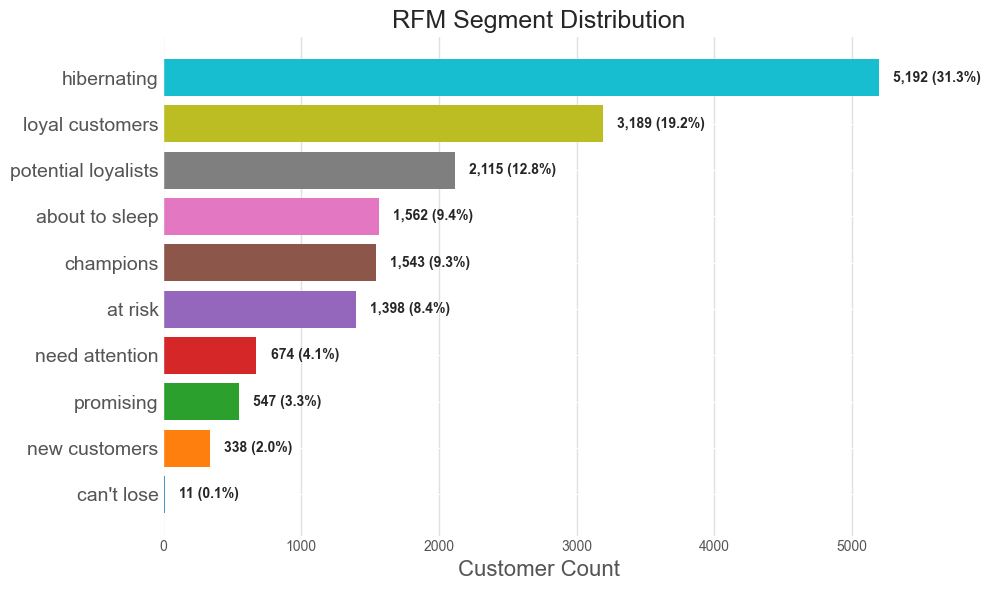

In [ ]:
plt.figure(figsize=(10, 6))
segment_counts_sorted = segment_counts.sort_values(ascending=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

bars = plt.barh(range(len(segment_counts_sorted)), segment_counts_sorted.values,
                color=colors[:len(segment_counts_sorted)])

plt.yticks(range(len(segment_counts_sorted)), segment_counts_sorted.index, fontsize=14)
plt.xlabel('Customer Count', fontsize=16)
plt.title('RFM Segment Distribution', fontsize=18)

plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.grid(True, axis='x', alpha=0.7, linestyle='-', linewidth=1, color='lightgray')
plt.gca().set_axisbelow(True)

for i, (segment, count) in enumerate(segment_counts_sorted.items()):
    percentage = count / segment_counts.sum() * 100
    plt.text(count + max(segment_counts_sorted.values) * 0.02, i,
             f'{count:,} ({percentage:.1f}%)',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

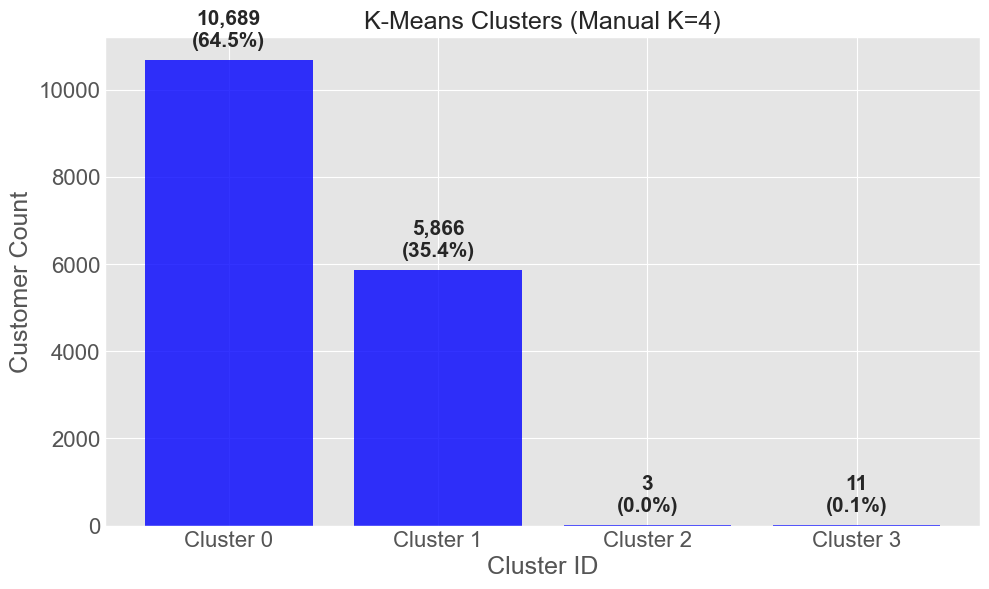

In [ ]:
plt.figure(figsize=(10, 6))

cluster_counts = rfm['kmeans_cluster'].value_counts().sort_index()
bars = plt.bar(range(len(cluster_counts)), cluster_counts.values, color='blue', alpha=0.8)
plt.title('K-Means Clusters (Manual K=4)', fontsize=18)
plt.xlabel('Cluster ID', fontsize=18)
plt.ylabel('Customer Count', fontsize=18)
plt.xticks(range(len(cluster_counts)), [f'Cluster {i}' for i in cluster_counts.index], fontsize=16)
plt.yticks(fontsize=16)

total_customers = cluster_counts.sum()
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
   percentage = count / total_customers * 100
   plt.text(i, count + max(cluster_counts.values) * 0.02,
            f'{count:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

CLV Visualization: Top 5% outliers removed (above $106958)
Displayed CLV range: $0 - $106958
Number of outliers removed: 829


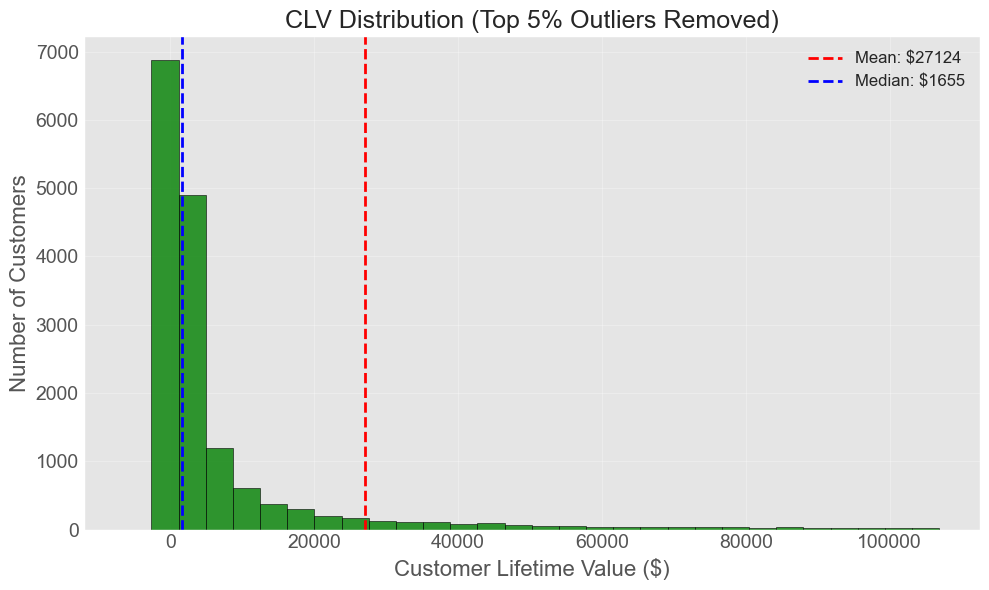

In [ ]:
plt.figure(figsize=(10, 6))

clv_95th = clv_data['clv'].quantile(0.95)
clv_filtered = clv_data['clv'][clv_data['clv'] <= clv_95th]

plt.hist(clv_filtered, bins=30, alpha=0.8, color='green', edgecolor='black', linewidth=0.5)
plt.title('CLV Distribution (Top 5% Outliers Removed)', fontsize=18)
plt.xlabel('Customer Lifetime Value ($)', fontsize=16)
plt.ylabel('Number of Customers', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, alpha=0.3)

mean_clv = clv_data['clv'].mean()
median_clv = clv_data['clv'].median()
plt.axvline(mean_clv, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_clv:.0f}')
plt.axvline(median_clv, color='blue', linestyle='--', linewidth=2, label=f'Median: ${median_clv:.0f}')
plt.legend(fontsize=12)

plt.tight_layout()

print(f"CLV Visualization: Top 5% outliers removed (above ${clv_95th:.0f})")
print(f"Displayed CLV range: $0 - ${clv_95th:.0f}")
print(f"Number of outliers removed: {len(clv_data) - len(clv_filtered)}")

(array([0, 1, 2, 3]),
 [Text(0, 0, 'High Risk'),
  Text(1, 0, 'Low Risk'),
  Text(2, 0, 'Critical Risk'),
  Text(3, 0, 'Medium Risk')])

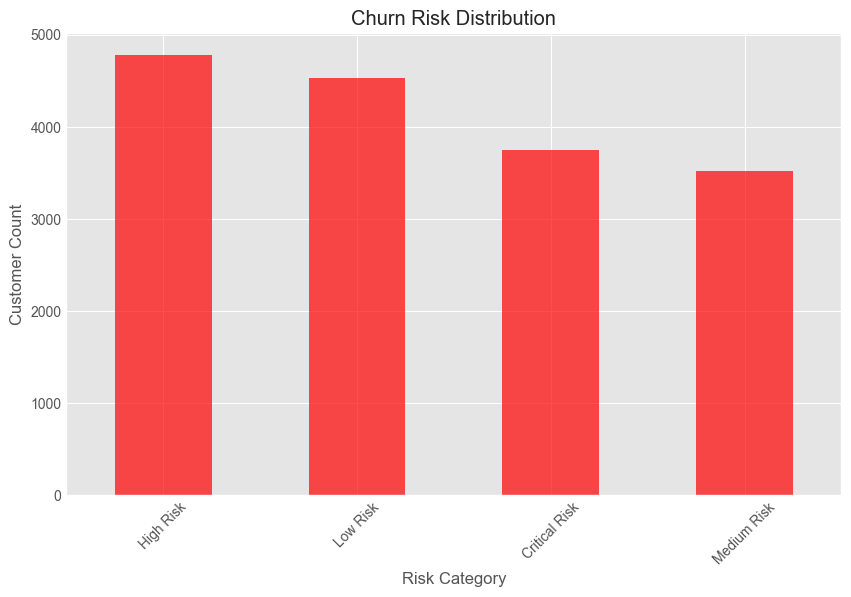

In [ ]:
plt.figure(figsize=(10, 6))
churn_features['churn_risk_category'].value_counts().plot(kind='bar', color='red', alpha=0.7)
plt.title('Churn Risk Distribution')
plt.xlabel('Risk Category')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)

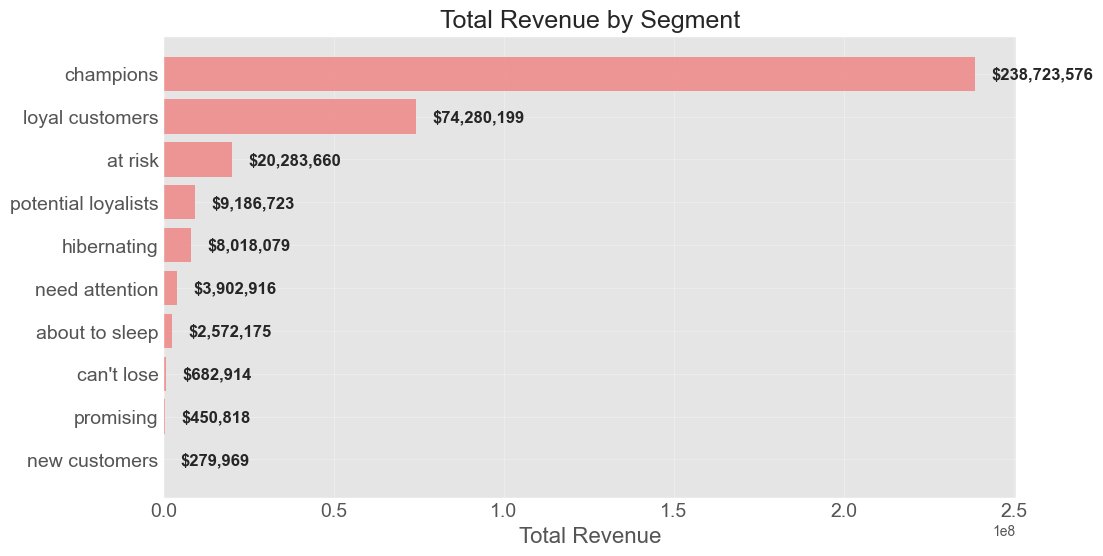

In [ ]:
plt.figure(figsize=(11, 6))
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(segment_revenue)), segment_revenue.values, color='lightcoral', alpha=0.8)
plt.yticks(range(len(segment_revenue)), segment_revenue.index, fontsize=14)
plt.title('Total Revenue by Segment', fontsize=18)
plt.xlabel('Total Revenue', fontsize=16)
plt.xticks(fontsize=14)
plt.grid(True, alpha=0.3)

for i, (segment, revenue) in enumerate(segment_revenue.items()):
   plt.text(revenue + max(segment_revenue.values) * 0.02, i, 
            f'${revenue:,.0f}', 
            va='center', fontsize=12, fontweight='bold')

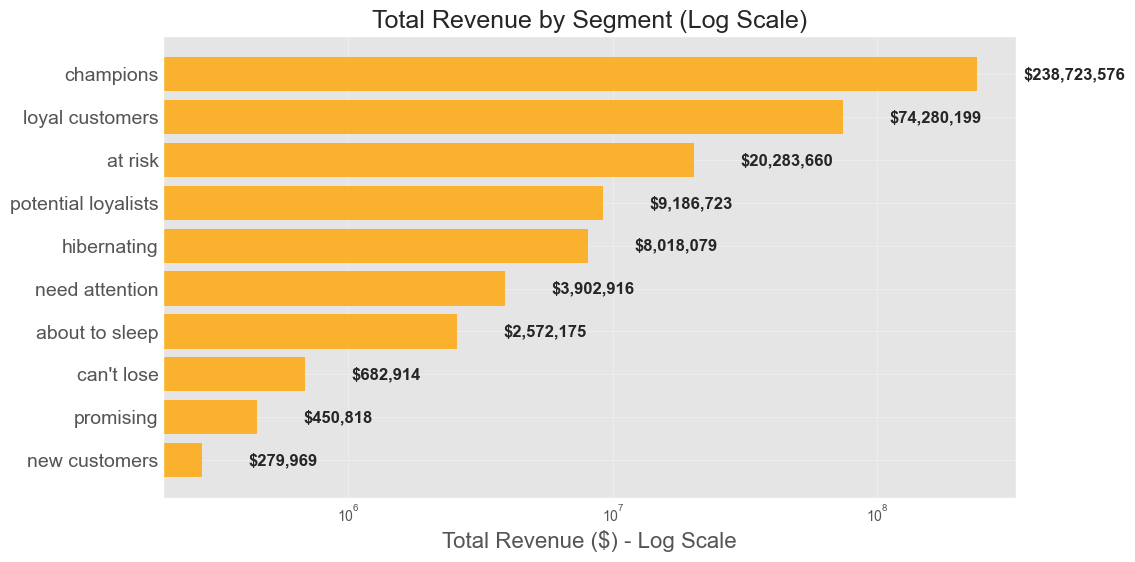

In [ ]:
plt.figure(figsize=(11, 6))
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(segment_revenue)), segment_revenue.values, color='orange', alpha=0.8)
plt.yticks(range(len(segment_revenue)), segment_revenue.index, fontsize=14)
plt.xscale('log')
plt.title('Total Revenue by Segment (Log Scale)', fontsize=18)
plt.xlabel('Total Revenue ($) - Log Scale', fontsize=16)
plt.grid(True, alpha=0.3)

for i, (segment, revenue) in enumerate(segment_revenue.items()):
   plt.text(revenue * 1.5, i,
            f'${revenue:,.0f}', 
            va='center', fontsize=12, fontweight='bold')

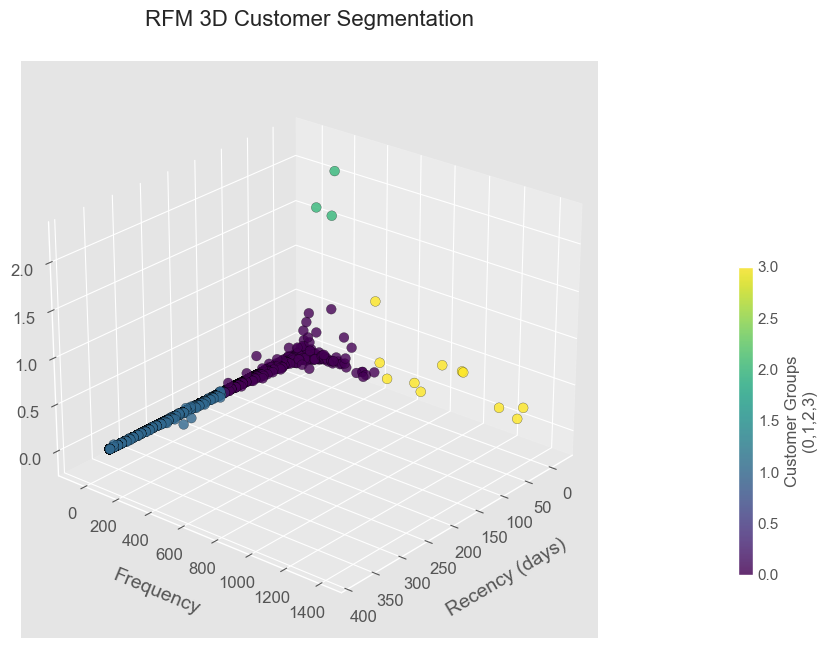

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.subplot(1, 2, 2, projection='3d')

scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'],
                    c=rfm['kmeans_cluster'], cmap='viridis', 
                    s=50, alpha=0.8, edgecolors='black', linewidth=0.2)

ax.set_xlabel('Recency (days)', fontsize=14, labelpad=12)
ax.set_ylabel('Frequency', fontsize=14, labelpad=12)
ax.set_zlabel('Monetary ($)', fontsize=14, labelpad=25)  # Z ekseni etiketi

ax.set_title('RFM 3D Customer Segmentation', fontsize=16, pad=25)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

ax.view_init(elev=25, azim=40)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
cbar.set_label('Customer Groups\n(0,1,2,3)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

pos = ax.get_position()
ax.set_position([pos.x0-0.15, pos.y0-0.05, pos.width*1.6, pos.height*1.5])

ax.margins(x=0.1, y=0.1, z=0.1)

Total 18 countries displayed


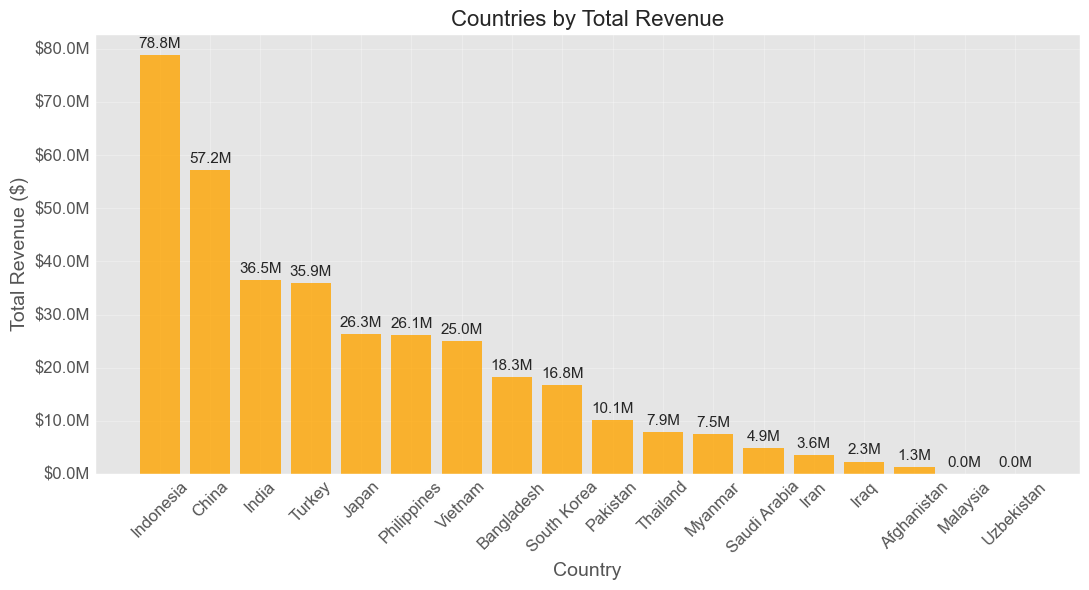

In [ ]:
plt.figure(figsize=(11, 6))
country_revenue = rfm.groupby('country')['monetary'].sum().sort_values(ascending=False)
bars = plt.bar(range(len(country_revenue)), country_revenue.values, color='orange', alpha=0.8)
plt.xticks(range(len(country_revenue)), country_revenue.index, rotation=45, fontsize=12)
plt.title('Countries by Total Revenue', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Revenue ($)', fontsize=14)
plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

for i, (country, revenue) in enumerate(country_revenue.items()):
   plt.text(i, revenue + max(country_revenue.values) * 0.01, 
            f'{revenue/1e6:.1f}M', 
            ha='center', va='bottom', fontsize=11)

plt.grid(True, alpha=0.3)

plt.tight_layout()

print(f"Total {len(country_revenue)} countries displayed")

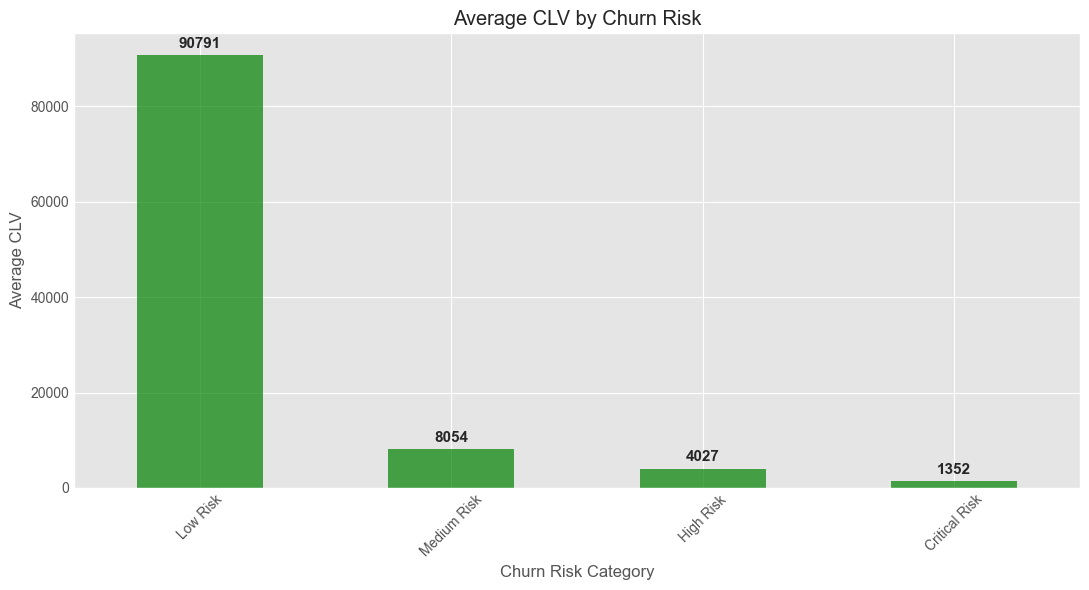

In [ ]:
plt.figure(figsize=(11, 6))
churn_clv_merged = churn_features[['customer_id', 'churn_risk_category']].merge(
   clv_data[['customer_id', 'clv']], on='customer_id', how='left'
)
churn_clv = churn_clv_merged.groupby('churn_risk_category')['clv'].mean()

bars = churn_clv.plot(kind='bar', color='green', alpha=0.7)
plt.title('Average CLV by Churn Risk')
plt.xlabel('Churn Risk Category')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)

ax = plt.gca()
for i, (category, value) in enumerate(churn_clv.items()):
   plt.text(i, value + max(churn_clv.values) * 0.01, 
            f'{value:.0f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
rfm.to_csv('../output/rfm_sales.csv', encoding='utf-8', index=False, float_format='%.2f')
print(f"\nRFM analysis completed and saved to '../output/rfm_sales.csv'")


RFM analysis completed and saved to '../output/rfm_sales.csv'


In [ ]:
segment_summary = rfm.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': ['mean', 'sum']
}).round(2)
segment_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary['Revenue_Percentage'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(2)
segment_summary['Customer_Percentage'] = (segment_summary['Customer_Count'] / len(rfm) * 100).round(2)

print("Segment Summary:")
print(segment_summary.sort_values('Total_Revenue', ascending=False))

Segment Summary:
                     Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
segment                                                                         
champions                      1543         6.66          40.05     154713.92   
loyal customers                3189        36.16          11.27      23292.63   
at risk                        1398       202.89           4.61      14509.06   
potential loyalists            2115        24.42           3.39       4343.60   
hibernating                    5192       247.90           1.33       1544.31   
need attention                  674        82.18           3.97       5790.68   
about to sleep                 1562        83.99           1.58       1646.72   
can't lose                       11       277.82          21.91      62083.06   
promising                       547        36.08           1.13        824.16   
new customers                   338         9.51           1.17        828.31   

          

In [ ]:
country_analysis = rfm.groupby('country').agg({
    'customer_id': 'count',
    'monetary': ['mean', 'sum'],
    'frequency': 'mean',
    'recency': 'mean'
}).round(2)

country_analysis.columns = ['Customer_Count', 'Avg_Monetary', 'Total_Revenue', 'Avg_Frequency', 'Avg_Recency']
country_analysis['Revenue_Per_Customer'] = (country_analysis['Total_Revenue'] / country_analysis['Customer_Count']).round(2)
country_analysis = country_analysis.sort_values('Total_Revenue', ascending=False)

print("Country Performance (Top 10):")
print(country_analysis.head(10))

Country Performance (Top 10):
             Customer_Count  Avg_Monetary  Total_Revenue  Avg_Frequency  \
country                                                                   
Indonesia              3660      21520.50    78765035.64           7.62   
China                  1935      29537.88    57155806.50           5.64   
India                  1582      23070.97    36498277.86           8.50   
Turkey                  423      84797.32    35869267.32          12.03   
Japan                   425      61997.58    26348970.18           7.99   
Philippines            1075      24302.28    26124951.18           9.84   
Vietnam                1752      14243.16    24954008.04           8.85   
Bangladesh             1531      11932.93    18269311.86           5.52   
South Korea             568      29504.64    16758633.72          13.92   
Pakistan               1363       7393.94    10077946.74           4.06   

             Avg_Recency  Revenue_Per_Customer  
country             

In [ ]:
recency_ranges = pd.cut(rfm['recency'], bins=[0, 30, 60, 90, 180, 365], 
                       labels=['0-30 days', '31-60 days', '61-90 days', '91-180 days', '180+ days'])
recency_analysis = rfm.groupby(recency_ranges, observed=True).agg({
    'customer_id': 'count',
    'monetary': 'sum'
})
recency_analysis.columns = ['Customer_Count', 'Total_Revenue']

print("Distribution by Last Purchase Time:")
print(recency_analysis)

print("\nDetailed Analysis:")
for period, data in recency_analysis.iterrows():
    avg_revenue = data['Total_Revenue'] / data['Customer_Count']
    print(f"   {period}: {data['Customer_Count']:,} customers, "
          f"Total: ${data['Total_Revenue']:,.0f}, "
          f"Avg per customer: ${avg_revenue:.2f}")

Distribution by Last Purchase Time:
             Customer_Count  Total_Revenue
recency                                   
0-30 days              5289   2.853859e+08
31-60 days             2135   2.312315e+07
61-90 days             1493   1.163593e+07
91-180 days            2872   2.187677e+07
180+ days              4780   1.635932e+07

Detailed Analysis:
   0-30 days: 5,289.0 customers, Total: $285,385,858, Avg per customer: $53958.38
   31-60 days: 2,135.0 customers, Total: $23,123,147, Avg per customer: $10830.51
   61-90 days: 1,493.0 customers, Total: $11,635,929, Avg per customer: $7793.66
   91-180 days: 2,872.0 customers, Total: $21,876,770, Avg per customer: $7617.26
   180+ days: 4,780.0 customers, Total: $16,359,323, Avg per customer: $3422.45


In [ ]:
total_customers = len(rfm)
total_revenue = rfm['monetary'].sum()
avg_customer_value = total_revenue / total_customers

risk_segments = ['at risk', 'about to sleep', "can't lose", 'hibernating']
risk_customers = rfm[rfm['segment'].isin(risk_segments)]
risk_percentage = len(risk_customers) / total_customers * 100
risk_revenue = risk_customers['monetary'].sum()
risk_revenue_percentage = risk_revenue / total_revenue * 100

print(f"\nGeneral Metrics:")
print(f"   - Total customers: {total_customers:,}")
print(f"   - Total revenue: ${total_revenue:,.2f}")
print(f"   - Average customer value: ${avg_customer_value:.2f}")
print(f"   - Customers at risk: {risk_percentage:.1f}% ({len(risk_customers):,} customers)")
print(f"   - Revenue at risk: {risk_revenue_percentage:.1f}% (${risk_revenue:,.2f})")


General Metrics:
   - Total customers: 16,569
   - Total revenue: $358,381,027.14
   - Average customer value: $21629.61
   - Customers at risk: 49.3% (8,163 customers)
   - Revenue at risk: 8.8% ($31,556,827.20)


In [ ]:
champions = rfm[rfm['segment'] == 'champions']
if len(champions) > 0:
    print(f"1. CHAMPIONS ({len(champions)} customers):")
    print(f"   - Average revenue: ${champions['monetary'].mean():.2f}")
    print(f"   - Total revenue: ${champions['monetary'].sum():.2f}")
    print(f"   - Action: VIP program, special discounts, early access")

at_risk = rfm[rfm['segment'] == 'at risk']
if len(at_risk) > 0:
    print(f"\n2. AT RISK ({len(at_risk)} customers):")
    print(f"   - Average last purchase: {at_risk['recency'].mean():.0f} days ago")
    print(f"   - Total potential loss: ${at_risk['monetary'].sum():.2f}")
    print(f"   - Action: Personalized campaigns, win-back emails")

cant_lose = rfm[rfm['segment'] == "can't lose"]
if len(cant_lose) > 0:
    print(f"\n3. CAN'T LOSE ({len(cant_lose)} customers):")
    print(f"   - Average revenue: ${cant_lose['monetary'].mean():.2f}")
    print(f"   - Total potential loss: ${cant_lose['monetary'].sum():.2f}")
    print(f"   - Action: URGENT intervention! Phone calls, special offers")

new_customers = rfm[rfm['segment'] == 'new customers']
if len(new_customers) > 0:
    print(f"\n4. NEW CUSTOMERS ({len(new_customers)} customers):")
    print(f"   - Average first purchase: ${new_customers['monetary'].mean():.2f}")
    print(f"   - Action: Welcome campaign, onboarding processes")

1. CHAMPIONS (1543 customers):
   - Average revenue: $154713.92
   - Total revenue: $238723575.54
   - Action: VIP program, special discounts, early access

2. AT RISK (1398 customers):
   - Average last purchase: 203 days ago
   - Total potential loss: $20283659.94
   - Action: Personalized campaigns, win-back emails

3. CAN'T LOSE (11 customers):
   - Average revenue: $62083.06
   - Total potential loss: $682913.70
   - Action: URGENT intervention! Phone calls, special offers

4. NEW CUSTOMERS (338 customers):
   - Average first purchase: $828.31
   - Action: Welcome campaign, onboarding processes


In [ ]:
high_potential_segments = ['at risk', 'need attention', 'about to sleep']
high_potential = rfm[rfm['segment'].isin(high_potential_segments)]

if len(high_potential) > 0:
    total_potential = high_potential['monetary'].sum()
    print(f"\n$ Recoverable Revenue Potential:")
    print(f"   - Total: ${total_potential:.2f}")
    print(f"   - Customer count: {len(high_potential):,}")
    print(f"   - Average customer value: ${total_potential/len(high_potential):.2f}")


$ Recoverable Revenue Potential:
   - Total: $26758751.28
   - Customer count: 3,634
   - Average customer value: $7363.44


In [ ]:
country_segments = rfm.groupby(['country', 'segment']).size().unstack(fill_value=0)
dominant_segments = country_segments.idxmax(axis=1)

print("\nDominant Segments by Country (ALL COUNTRIES):")
for country, segment in dominant_segments.items():
    customer_count = country_segments.loc[country, segment]
    total_customers = country_segments.loc[country].sum()
    percentage = (customer_count / total_customers * 100)
    print(f"   {country}: {segment} ({percentage:.1f}% - {customer_count} customers)")

print(f"\nTOP 10 Countries by Customer Count:")
top_countries = rfm['country'].value_counts().head(10)
for country, count in top_countries.items():
    print(f"   {country}: {count} customers")


Dominant Segments by Country (ALL COUNTRIES):
   Afghanistan: hibernating (37.6% - 77 customers)
   Bangladesh: hibernating (35.8% - 548 customers)
   China: hibernating (42.0% - 813 customers)
   India: hibernating (25.8% - 408 customers)
   Indonesia: hibernating (26.2% - 958 customers)
   Iran: hibernating (34.8% - 172 customers)
   Iraq: hibernating (29.4% - 37 customers)
   Japan: hibernating (45.4% - 193 customers)
   Malaysia: potential loyalists (100.0% - 1 customers)
   Myanmar: hibernating (32.3% - 193 customers)
   Pakistan: hibernating (35.1% - 479 customers)
   Philippines: hibernating (28.8% - 310 customers)
   Saudi Arabia: loyal customers (23.4% - 57 customers)
   South Korea: hibernating (28.7% - 163 customers)
   Thailand: hibernating (27.1% - 159 customers)
   Turkey: hibernating (28.6% - 121 customers)
   Uzbekistan: hibernating (100.0% - 1 customers)
   Vietnam: hibernating (28.9% - 506 customers)

TOP 10 Countries by Customer Count:
   Indonesia: 3660 customers
 

In [ ]:
with pd.ExcelWriter('../output/advanced_rfm_report.xlsx', engine='openpyxl') as writer:
    rfm.to_excel(writer, sheet_name='RFM_Data', index=False)
    
    rfm[['customer_id', 'kmeans_cluster', 'dbscan_cluster', 'segment']].to_excel(
        writer, sheet_name='Clustering_Results', index=False)
    
    clv_data[['customer_id', 'clv', 'clv_quartile', 'aov', 'purchase_frequency']].to_excel(
        writer, sheet_name='CLV_Analysis', index=False)
    
    churn_features[['customer_id', 'churn_risk_score', 'churn_risk_category', 
                   'recency_risk', 'frequency_risk', 'monetary_risk']].to_excel(
        writer, sheet_name='Churn_Risk', index=False)
    
    segment_summary.to_excel(writer, sheet_name='Segment_Summary')
    
    country_analysis.to_excel(writer, sheet_name='Country_Analysis')
    
    recency_analysis.to_excel(writer, sheet_name='Recency_Analysis')
    
    retention_table.to_excel(writer, sheet_name='Cohort_Analysis')
    
    clv_rfm_comparison.to_excel(writer, sheet_name='CLV_RFM_Comparison')

print(f"\nAdvanced analysis completed and saved to '../output/advanced_rfm_report.xlsx'")


Advanced analysis completed and saved to '../output/advanced_rfm_report.xlsx'


In [ ]:
print("Completed Analyses:")
print("   1. Traditional RFM Segmentation")
print("   2. K-Means Clustering (Finding optimal cluster count)")
print("   3. DBSCAN Clustering (Noise detection)")
print("   4. Cohort Analysis (Customer lifecycle)")
print("   5. Customer Lifetime Value (CLV) Calculation")
print("   6. Churn Prediction Features")
print("   7. Advanced Visualizations")

print(f"\nKey Statistics:")
print(f"   - Total customers: {total_customers:,}")
print(f"   - Optimal K-Means clusters: {optimal_k}")
print(f"   - DBSCAN cluster count: {n_clusters_dbscan}")
print(f"   - Average CLV: ${clv_data['clv'].mean():.2f}")
print(f"   - Critical risk customers: {len(critical_customers):,}")

print(f"\nBusiness Value:")
print(f"   - Total revenue: ${total_revenue:,.2f}")
print(f"   - Revenue at risk: ${risk_revenue:,.2f} ({risk_revenue_percentage:.1f}%)")
print(f"   - Recoverable potential: ${total_potential:.2f}")

print(f"\nNext Steps:")
print("   1. Convert this code for Apache Spark migration")
print("   2. Expand model by adding behavioral data")
print("   3. Set up ETL pipeline for real-time segmentation")
print("   4. Develop API for CRM integration")

print(f"\nModel Performance Metrics:")
print(f"   - K-Means Silhouette Score: {max(silhouette_scores):.3f}")
print(f"   - Number of segments: {len(rfm['segment'].unique())}")
print(f"   - CLV variation: {clv_data['clv'].std():.2f}")

Completed Analyses:
   1. Traditional RFM Segmentation
   2. K-Means Clustering (Finding optimal cluster count)
   3. DBSCAN Clustering (Noise detection)
   4. Cohort Analysis (Customer lifecycle)
   5. Customer Lifetime Value (CLV) Calculation
   6. Churn Prediction Features
   7. Advanced Visualizations

Key Statistics:
   - Total customers: 1,752
   - Optimal K-Means clusters: 2
   - DBSCAN cluster count: 11
   - Average CLV: $64462657.56
   - Critical risk customers: 3,745

Business Value:
   - Total revenue: $358,381,027.14
   - Revenue at risk: $31,556,827.20 (8.8%)
   - Recoverable potential: $26758751.28

Next Steps:
   1. Convert this code for Apache Spark migration
   2. Expand model by adding behavioral data
   3. Set up ETL pipeline for real-time segmentation
   4. Develop API for CRM integration

Model Performance Metrics:
   - K-Means Silhouette Score: 0.969
   - Number of segments: 10
   - CLV variation: 1538579076.43
